#### 1. Financial Data Structures
<br> <p style = 'text-align:justify;'>This section containes data structuring techniques explained in book 'Advances In Financial Machine Learning'.
<br> In quant parlence, each observation is known called a 'bar'; bars combine to form a data sample
<br> Various standard and alternative approaches to convert raw tick data into a meaningful data sample were discussed.</p>
    * The standard approach comprises of:
        1. time bars that is obtained by sampling at a fixed time interval; 
        2. tick bars that is extracted each time a pre-defined no. of transactions take place;
        3. volume bars that sample every time a pre-defined amount of security's units have been traded; and
        4. dollar bars (or euro/ yen/ yuan etc... bars), which are formed by sampling every-time a pre-defined market value is exchanged.
    * Of all the standard approaches, dollar bars are most appealing for their robust statistical properties (Gaussian and IID) and acommodates stock splits and other corporate events, which even volume bars also miss.
    * The alternative approach are various information driven bars, which is for the purpose of sampling more information when new information arrives to the market.
<font style: arial> Note: <br>For the submission purposes, we extracted dollar bars from the provided code snippets; however, due to buggy nature of labeling and feature creating codes, we switched back to ohlc time bars.</font><br>
The tick source: [here](http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask&bp=1&user=guest).
<br> My repo: [here](https://github.com/NeelkanthMehta/WQU_650-ml_for_finance.git).
<br> <font size=1.5> Please maintain same folder structure as in the repo to meet the dependencies for following libraries.</font>

In [5]:
# Change the work directory here:
cd ~/Documents/WQU/WQU_650-ml_for_finance/intro_to_deep_learning/

/home/neelkanth/Documents/WQU/WQU_650-ml_for_finance/intro_to_deep_learning


In [6]:
# Importing standard libraries
import sys
import time
import re
import os
import json
from pathlib import PurePath, Path

# Importing scientific libraries
import numpy as np
import pandas as pd
os.environ['THEANO_FLAGS'] = 'device=cpu, floatX=float32'
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import pymc3 as pm
from theano import shared, theano as tt
import ta

# importing visual libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.weight'] = 'medium'

blue, grean, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# Import util libs
import pyarrow as palind
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

# user defined libraries
from src.utils.utils import *
from src.features.bars import get_imbalance
import src.features.bars as brs
import src.features.snippets as snp

RANDOM_STATE = 777

In [7]:
infp = PurePath('./data/IVE_tickbidask.txt')

#### loading and cleaning data

In [8]:
"""Reading and Cleaning data"""

def read_kibot_ticks(fp):
    cols = list(map(str.lower, ['Date', 'Time', 'Price', 'Bid', 'Ask', 'Size']))
    df = (pd.read_csv(fp, header=None)
    .rename(columns=dict(zip(range(len(cols)), cols)))
    .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'], format='%m/%d/%Y%H:%M:%S')))
    .assign(v = lambda df: df['size']) # volume
    .assign(dv= lambda df: df['price']*df['size']) # dollar volume
    .drop(['date', 'time'], axis=1)
    .set_index('dates')
    .drop_duplicates())
    return df

In [9]:
# Creating a tick dataframe
df = read_kibot_ticks(infp)

In [10]:
# Printing the output fataframe
outfp = PurePath('./data/IVE_tickbidask.parq')
df.to_parquet(outfp)

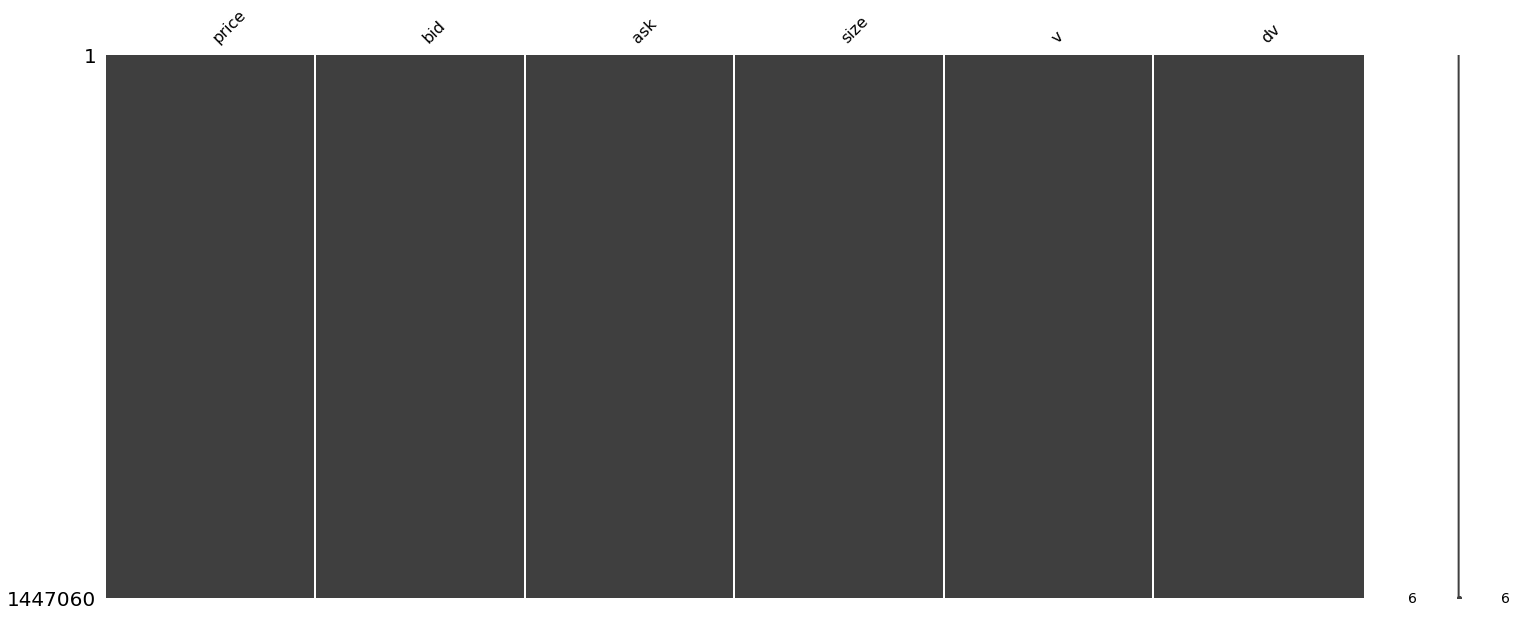

In [11]:
# missing numbers
msno.matrix(df)

In [12]:
"""Eliminating outliers from the dataset"""
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y-median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    
    modified_z_score = 0.6745 * diff/ med_abs_deviation
    return modified_z_score > thresh

In [13]:
# defining variable mad
mad = mad_outlier(df.price.values.reshape(-1,1))

# removing outliers
df = df.loc[~mad]

In [14]:
"""Exporting the processed data to file"""
outfp = PurePath('./data/clean_IVE_fut_prices.parq')
df.to_parquet(outfp)

In [15]:
"""Creating Dollar Bars"""
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    
    # args
        df: pd.DataFrame()
        dv_column: name of dollar volume bar
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx].drop_duplicates()

In [16]:
# loading data - if not already loaded
df = pd.read_parquet('./data/clean_IVE_fut_prices.parq')
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-31 16:10:00  109.65  108.01  116.99      0      0        0.00
2018-10-31 16:17:27  109.63  109.63  116.99    190    190    20829.70
2018-10-31 18:25:11  109.65  108.11  109.90  14993  14993  1643982.45
2018-10-31 18:30:00  109.65  108.11  109.90      0      0        0.00
2018-10-31 20:00:00  109.65  109.14  109.90      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447049 entries, 2009-09-28 09:30:00 to 2018-10-31 20:00:00
Data columns (total 6 columns):
price    1447049 non-null float64
bid      1447049 non-null float64
ask      1447049 non-null float64
size     1447049 non-null int6

In [17]:
# executing the function:
dollar_M = 1_000_000  # arbitrary
print(f"dollar threshold: {dollar_M:,}")
dv_bar_df = dollar_bar_df(df,'dv', dollar_M)
cprint(dv_bar_df)

  6%|▌         | 88489/1447049 [00:00<00:01, 884888.73it/s]

dollar threshold: 1,000,000


100%|██████████| 1447049/1447049 [00:00<00:00, 1830031.47it/s]


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-31 15:56:55  109.73  109.74  109.74    800    800    87784.00
2018-10-31 15:56:55  109.73  109.73  109.74   2700   2700   296271.00
2018-10-31 15:59:33  109.60  109.60  109.62    700    700    76720.00
2018-10-31 16:00:00  109.65  109.62  109.63  68570  68570  7518700.50
2018-10-31 18:25:11  109.65  108.11  109.90  14993  14993  1643982.45
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52200 entries, 2009-09-28 09:46:35 to 2018-10-31 18:25:11
Data columns (total 6 columns):
price    52200 non-null float64
bid      52200 non-null float64
ask      52200 non-null float64
size     52200 non-null int64
v       

In [18]:
# Resampling
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf= sub[price_col].loc[date]
    return xdf, xtdf

xDate = '2009-10-01' #'2017-10-4'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)

In [20]:
"""Exporting the Dollar Bar"""
# Please cheange the file path as required
dv_bar_df.to_csv('./data/dataset.csv', sep=',', header=True)

#### Generate labels and features

In [21]:
dataset = pd.read_csv('./data/dataset.csv', index_col=0)
dataset['dv'] = dataset['dv'].astype(np.int64)
dataset.index = pd.to_datetime(dataset.index)

In [22]:
# Creating ohlc data
price = dataset['price'].resample('10Min').ohlc().fillna(method='ffill').dropna(how='all')

df = price.merge(dataset[['v','dv']], how='outer', left_index=True, right_index=True).fillna(method='ffill').dropna(how='all')
df['v'][0], df['dv'][0] = 0, 0

cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                       open    high     low   close        v         dv
dates                                                                  
2018-10-31 17:50:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:00:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:10:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:20:00  109.65  109.65  109.65  109.65  68570.0  7518700.0
2018-10-31 18:25:11  109.65  109.65  109.65  109.65  14993.0  1643982.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528918 entries, 2009-09-28 09:40:00 to 2018-10-31 18:25:11
Data columns (total 6 columns):
open     528918 non-null float64
high     528918 non-null float64
low      528918 non-null float64
close    528918 non-

'''For details, ref: [documentation of TA library](https://bit.ly/2CZp7OB)'''

#### Generating Features form the ohlc data.
***Momentum Indicators:***
1. Awsome Oscillator is a 34-period simple moving average, plotted through the central points of the bars (H+L)/2, and subtracted from the 5-period simple moving average, graphed across the central points of the bars (H+L)/2.</p>
2. Relative Strength Index (RSI) Compares the magnitude of recent gains and losses over a specified time period to measure speed and change of price movements of a security.
3. True Strength Index (TSI) shows both trend and overbought/ oversold conditions.
4. Williams R or %R is an inverse to stochastic osilator, which reflects the level of closing price relative to highest high for the look-back period.

***Volume Indicators:***
5. Ease of Movement is the relation between asset's price and its volume. A higher  index indicates price is moving on low volume and *vice versa*.
6. Chaikin Money Flow measures the amount of money flow volume over a specific period.
7. Force Index illustrates the strength of actual buying or selling pressure.

***Trend Indicator:***
8. MACD Is a trend-following momentum indicator that shows relationship between two moving average of prices.

In [27]:
#Awsome Oscillator:
ao = ta.momentum.ao(high=df['high'], low=df['low'], fillna=True)

# Relative Strength Index
rsi = ta.momentum.rsi(close=df['close'],fillna = True)

# True Strength Index
tsi = ta.momentum.tsi(close=df['close'], fillna=True)

# Williams R
r_pct = ta.momentum.wr(high=df['high'], low=df['low'], close=df['close'], fillna=True) 

# East of Movement
EoM = ta.volume.ease_of_movement(high=df['high'], low=df['low'], close=df['close'], volume=df['v'],fillna=True) 

# Chaikin Money Flow
cmf = ta.volume.chaikin_money_flow(high=df['high'], low=df['low'], close=df['close'], volume=df['v'], fillna=True) 

# Force Index
force_index = ta.volume.force_index(close=df['close'], volume=df['v'], fillna=True)

# MACD
MACD = ta.trend.macd(close=df['close'], fillna=True)

In [29]:
# Combining eight features in single df
features = pd.concat((ao, rsi, tsi, MACD, r_pct, EoM, cmf, force_index), axis=1)
cols = ['ao', 'rsi', 'tsi', 'macd', 'r_pct', 'EoM', 'cmf', 'force_index']
features.columns = cols

#### Standardizing the dataset
<br> <p style = 'text-align: justify;'> Before performing PCA on the dataset it is necessary to standardize the dataset. This is because, when multiplying to the identity matrix, we need to have similar values in the X(dataset).
<br> Failing to standardize the data might lead to PCA algorithm assume higher emphesis on higher numerical valued feature. For e.g., a feature might range in 100,000 to 200,000 might be considered over the feature ranging between 1 to 100. this is the case when units of measurement vary across the features.
<br> standardization is applied by: $$std(x_i) = \frac{x_i-\bar{x}}{\sigma_x}$$
<br> The alternative approach is normalization; however, of the two approaches, standardization retains the extrem outliers, which is desirable while performing PCA.</p>

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
standard = sc.fit_transform(features)

#### Feature Extraction

***Principal Component Analysis*** consists of creating linearly uncorrelated features input predictor features or principal components based on orthogonal transformation statistical procedure of possily correlated input predictors.<br> Its main advantage over feature selection is higher discriminaatory effictiveness.<br> Its main disadvantages against feature selection are **loss of data interpretability** and no savings in data acquisition costs.
<br> steps are:
1. <p style = 'text-align: justify;'> calculate $i$ linear combinations:</p> $$\sum^i y_i = \sum^i \beta_{i}\cdot x_{i}$$
2. <p style = 'text-align: justify;'> calculate first principal component with max variance and constrained by sum of squared coefficients equal to 1:</p>
\begin{align}
max(\sigma^2_{y,i}) & = \sum^i_{j=1}\sum^i_{k=1}\beta_{1,j} \cdot \beta_{1,k} \sigma_{j,k} \\
\text{subject to...} \\
const(y_i) & = \sum^i_{i=1}\beta_{1,t^2}=1
\end{align}
3. <p style = 'text-align: justify;'> calculate second principal component with remaining maximum variance constrained by sum of squared coefficients equal to one and uncorrelated to first principal component:</p>
\begin{align}
max(\sigma^2_{y2}) & = \sum^i_{j=1}\sum^i_{k=1}\beta_{2,j}\beta_{2,k}\sigma_{j,k}\\
\text{subject to...}\\
const_{a}(y2)&=\sum^i_{l=1}\beta_{2l^2}=1\\
\text{and,}\\
const_{b}(\sigma_{y1,y2})&=\sum^i_{j=1}\sum^i_{k=1}\beta_{1j}\beta_{2k}\sigma_{jk}=0
\end{align}
4. Repeat the step #3 for the subsequent principal components.

In [31]:
# Implementing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None, svd_solver='full')
processed = pca.fit_transform(standard)

In [32]:
pca.explained_variance_ratio_

array([0.38908885, 0.17614144, 0.13844514, 0.12495265, 0.09305906,
       0.05154532, 0.02197368, 0.00479386])

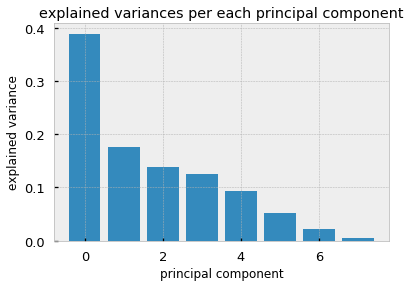

In [61]:
fig, ax = plt.subplots()
ax.bar(x=list(range(0, pca.n_components_)), height=pca.explained_variance_ratio_)
ax.set_title('explained variances per each principal component')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [33]:
# The index are n components and columns are features
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7
0,-0.475328,-0.419216,-0.424259,-0.486740,-0.369571,-0.120375,-0.173867,0.010330
1,-0.285024,0.115428,-0.077000,-0.304607,0.510330,-0.309534,0.671173,0.001484
2,-0.151259,0.408471,0.431898,-0.165594,-0.169257,-0.670467,-0.340497,-0.046933
3,-0.004825,-0.018148,-0.022357,-0.001983,0.009925,0.038448,0.010000,-0.998733
4,0.422083,-0.432475,-0.307449,0.321037,0.095271,-0.654136,-0.010040,-0.012271
5,0.009414,0.356010,-0.512182,-0.098004,0.543702,0.050838,-0.550444,0.006994
6,-0.197498,-0.571600,0.507244,-0.054298,0.519173,0.065799,-0.316438,0.004617
7,-0.672811,0.057029,-0.113526,0.726124,-0.002139,-0.062344,-0.006132,0.000831


#### Model Selection

<p style= 'text-align:justify;'>Generally, the performance of the supervised learning algorithm is tested on the dataset other than the dataset that it was initially trained.<br> Tor this purpose we apportion the dataset into two/ three parts known as train, validation and test set. This is a general practices while developing a machine learning algorithm. However, it has certain limitations; first, I provides just one estimator. Second, changing splitting pattern can significantly change testing accuracy - succeptible to selection bias.
<br> Apparently, we might want to split the dataset into several train-test sets. That's where cross-validation comes into pitcure. The advantage of cross-validation over simple splitting of data is that it provides more 'generalizable' estimators.</p>
<p style= 'test-align:justify;'> In cross-validation, train set is divided into $\frac{1}{n}$ bins, a.k.a 'folds'. The model is then trained on $^kP_1$ samples. The estimated error is the expected error from the $k$ fold dataset. We thereby we ensure we donot overfit the data and select the best performing model.</p>
<p style= 'text-align:justify;'> Performing $k$-fold cross validation on financial time-series data may pose another challenge, i.e., look-ahead bias. To tackle with this problem, a roll-forward $k$-fold cross validation is performed.<br> Here, of the $k$ folds, folds 1 & 2 is used as training and test data, then 2 & 3 and so on...This ensures that the training data is always before testing data.<br> However, autho Marcos LoPez (Advances in Financial Machine Learning) argue that roll-forward method too has drawbacks. First, only single scenario is tested, which could easily be overfit. Second, roll-forward is not necessarily representative of future performance, which is a potential for bias introduction. Third, the initial decisions are made on smaller ($\frac{3}{4}\frac{t_0}{T}+\frac{1}{4}$) portions of the total sample.
<p style= 'text-align:justify;'> The solution recommended by the author is, Combinatorial Purged Cross-Valuation. Here, $T$ observations are split into  $N$ groups without shuffling, where $n=1,...N-1$ of size $\frac{T}{N}$. The $n$th group is of size $T-\frac{T}{N}(N-1)$. Thus for testing set of size $k$ groups, the number of possible training/ testing splits is: $^NC_{N-K}=\frac{\Pi^{k-1}_{i=0}(N-i)}{k!}$